In [120]:
%matplotlib inline
import folium
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import re
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error,accuracy_score
import statsmodels.formula.api as smf

In [93]:
df = pd.read_csv('MERGED2011_PP.csv', header=0)

In [94]:
df.head()

,UNITID,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,NPCURL,...,PELL_RPY_3YR_RT_SUPP,NOPELL_RPY_3YR_RT_SUPP,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP,C150_L4_POOLED_SUPP,C150_4_POOLED_SUPP,C200_L4_POOLED_SUPP,C200_4_POOLED_SUPP
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,NaN,NaN,NaN,...,0.455279503106,0.5,0.504513540622,0.420550847458,0.470229007634,0.455089820359,NaN,NaN,NaN,NaN
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,NaN,...,0.732501356484,0.844773790952,0.790354330709,0.757345971564,0.761989342806,0.797997644287,NaN,NaN,NaN,NaN
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,NaN,NaN,NaN,...,0.5,0.636363636364,0.487012987013,0.609523809524,0.515625,0.577319587629,NaN,NaN,NaN,NaN
3,100706,105500,1055,University of Alabama at Huntsville,Huntsville,AL,35899,NaN,NaN,NaN,...,0.735384615385,0.839116719243,0.775700934579,0.77975376197,0.774757281553,0.788643533123,NaN,NaN,NaN,NaN
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,NaN,NaN,NaN,...,0.308108108108,0.425287356322,0.354420731707,0.290803645402,0.300215982721,0.346017699115,NaN,NaN,NaN,NaN


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7675 entries, 0 to 7674
Columns: 1729 entries, UNITID to C200_4_POOLED_SUPP
dtypes: float64(502), int64(10), object(1217)
memory usage: 101.2+ MB


In [97]:
# number of rows
len(df)

7675

In [98]:
#number of columns: 
len(df.columns)

1729

In [99]:
dd = pd.read_csv('CollegeScorecardDataDictionary-09-12-2015.csv', header=0)

In [100]:
dd.head()

,NAME OF DATA ELEMENT,Year,dev-category,developer-friendly name,VARIABLE NAME,API data type,label,VALUE,LABEL,SCORECARD? Y/N,SOURCE,NOTES
0,Unit ID for institution,NaN,root,id,UNITID,integer,NaN,NaN,NaN,NaN,IPEDS,NaN
1,8-digit OPE ID for institution,NaN,root,ope8_id,OPEID,integer,NaN,NaN,NaN,NaN,IPEDS,NaN
2,6-digit OPE ID for institution,NaN,root,ope6_id,opeid6,integer,NaN,NaN,NaN,NaN,IPEDS,NaN
3,Institution name,2013,school,name,INSTNM,string,NaN,NaN,NaN,Y,IPEDS,NaN
4,City,2013,school,city,CITY,string,NaN,NaN,NaN,Y,IPEDS,NaN


In [101]:
dd['SOURCE'].value_counts()

NSLDS       1179
IPEDS        433
Treasury     105
FSA            3
Name: SOURCE, dtype: int64

In [102]:
earning_cols = dd[dd['dev-category'] == 'earnings']['VARIABLE NAME']
print("Length: ",len(earning_cols))
print(earning_cols)

Length:  73
1827           count_ed
1860     count_nwne_p10
1861      count_wne_p10
1862    mn_earn_wne_p10
1863    md_earn_wne_p10
             ...       
1927      count_nwne_p9
1928       count_wne_p9
1929     mn_earn_wne_p9
1930     sd_earn_wne_p9
1931          gt_25k_p9
Name: VARIABLE NAME, Length: 73, dtype: object


In [103]:
repayment_cols = dd[dd['dev-category'] == 'repayment']['VARIABLE NAME']
print("Length: ",len(repayment_cols))
print(repayment_cols)

Length:  130
662                            CDR2
663                            CDR3
1574                     RPY_1YR_RT
1575               COMPL_RPY_1YR_RT
1576              NONCOM_RPY_1YR_RT
                   ...             
1944         NOPELL_RPY_3YR_RT_SUPP
1945         FEMALE_RPY_3YR_RT_SUPP
1946           MALE_RPY_3YR_RT_SUPP
1947       FIRSTGEN_RPY_3YR_RT_SUPP
1948    NOTFIRSTGEN_RPY_3YR_RT_SUPP
Name: VARIABLE NAME, Length: 130, dtype: object


In [104]:
removed_cols = ['UNITID', 'OPEID','opeid6', 'ZIP', 'INSTNM', 'CITY', 'sch_deg', 'st_fips']

total_len = df.shape[0]

for col in df.columns:
    
    bad_count = sum(df[col].isnull())
    if df[col].dtype == 'object':
        bad_count += df.loc[df[col] == 'PrivacySuppressed'].shape[0]
        
    if bad_count > total_len * (1 / 4.0):
        removed_cols.append(col)
    
print("length: ",len(removed_cols))

length:  1348


In [105]:
removed_cols_set = set(removed_cols)
removed_cols_set = removed_cols_set.union(list(earning_cols.values))
removed_cols_set = removed_cols_set.union(list(repayment_cols.values))

len(removed_cols_set)

1393

In [106]:
cols_to_include = {'mn_earn_wne_p10','md_earn_wne_p10'}
removed_cols_set = removed_cols_set - cols_to_include
len(removed_cols_set)

1391

In [107]:
removed_cols = list(removed_cols_set)
df.drop(removed_cols, axis=1, inplace=True)
df.shape

(7675, 338)

In [108]:
df

,STABBR,HCM2,main,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,region,PCIP01,PCIP03,...,IND_INC_N,PAR_ED_N,APPL_SCH_N,SEPAR_DT_MDN,SEPAR_DT_N,mn_earn_wne_p10,md_earn_wne_p10,DEBT_MDN_SUPP,GRAD_DEBT_MDN_SUPP,GRAD_DEBT_MDN10YR_SUPP
0,AL,0,1,1,3,4,1,5.0,0.0388,0.0145,...,421,2091,2422,19482,2289,35300,31400,19484.5,29573,328.32092465
1,AL,0,1,1,3,4,1,5.0,0.0000,0.0000,...,1812,4872,5270,19605,4759,46300,40300,16000,20700,229.812435
2,AL,0,1,1,3,4,2,5.0,0.0000,0.0000,...,341,309,375,19103,352,42100,38100,11772,22370,248.3528585
3,AL,0,1,1,3,4,1,5.0,0.0000,0.0000,...,883,2177,2339,19565,2082,52700,46600,15744.5,22000,244.2451
4,AL,0,1,1,3,4,1,5.0,0.0000,0.0000,...,566,2552,3005,19395,2762,30700,27800,17508.5,31000,344.16355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7670,CA,0,0,2,0,0,3,8.0,NaN,NaN,...,578,728,856,19177,810,NaN,NaN,9500,9500,105.469475
7671,CA,0,0,5,0,0,1,8.0,NaN,NaN,...,549,443,602,NaN,0,NaN,NaN,NaN,NaN,NaN
7672,CA,0,0,5,0,0,1,8.0,NaN,NaN,...,549,443,602,NaN,0,NaN,NaN,NaN,NaN,NaN
7673,CA,0,0,5,0,0,1,8.0,NaN,NaN,...,549,443,602,NaN,0,NaN,NaN,NaN,NaN,NaN


In [109]:
df = df.dropna()
df

,STABBR,HCM2,main,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,region,PCIP01,PCIP03,...,IND_INC_N,PAR_ED_N,APPL_SCH_N,SEPAR_DT_MDN,SEPAR_DT_N,mn_earn_wne_p10,md_earn_wne_p10,DEBT_MDN_SUPP,GRAD_DEBT_MDN_SUPP,GRAD_DEBT_MDN10YR_SUPP
0,AL,0,1,1,3,4,1,5.0,0.0388,0.0145,...,421,2091,2422,19482,2289,35300,31400,19484.5,29573,328.32092465
1,AL,0,1,1,3,4,1,5.0,0.0000,0.0000,...,1812,4872,5270,19605,4759,46300,40300,16000,20700,229.812435
2,AL,0,1,1,3,4,2,5.0,0.0000,0.0000,...,341,309,375,19103,352,42100,38100,11772,22370,248.3528585
3,AL,0,1,1,3,4,1,5.0,0.0000,0.0000,...,883,2177,2339,19565,2082,52700,46600,15744.5,22000,244.2451
4,AL,0,1,1,3,4,1,5.0,0.0000,0.0000,...,566,2552,3005,19395,2762,30700,27800,17508.5,31000,344.16355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7365,WA,0,1,1,3,3,2,8.0,0.0000,0.0000,...,276,1227,1299,379852,1242,44400,41200,19500,24100,267.559405
7366,OK,0,1,3,1,1,3,6.0,0.0000,0.0000,...,276,171,338,19032,310,28200,26000,2860,3766,41.8103203
7367,MA,0,1,1,3,4,2,1.0,0.0000,0.0000,...,1387,2204,2609,379852,2524,47800,45100,19625,22125,245.63285625
7368,CA,0,0,2,1,1,3,8.0,0.0000,0.0000,...,127,170,208,19417,192,51100,47500,11739.5,12236,135.8446838


In [110]:
df.isna()

,STABBR,HCM2,main,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,region,PCIP01,PCIP03,...,IND_INC_N,PAR_ED_N,APPL_SCH_N,SEPAR_DT_MDN,SEPAR_DT_N,mn_earn_wne_p10,md_earn_wne_p10,DEBT_MDN_SUPP,GRAD_DEBT_MDN_SUPP,GRAD_DEBT_MDN10YR_SUPP
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7365,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7366,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7367,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7368,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [111]:
def is_privacy_surpressed(row):
    for col, value in row.iteritems():
        if value == 'PrivacySuppressed':
            return True
        
    return False
    
privacy_surpressed = df.apply(is_privacy_surpressed, axis=1)
df = df[~privacy_surpressed]
df.shape

(2701, 338)

In [112]:
previous_var = None
cat_vars = {'STABBR'}
for index, row in dd.iterrows():
    if (type(row['NAME OF DATA ELEMENT']) == float) and np.isnan(row['NAME OF DATA ELEMENT']):
        cat_vars.add(previous_var)
    else:
        previous_var = row['VARIABLE NAME']

print("length: ",len(cat_vars)) 
cat_vars

length:  24


{'AANAPII',
 'ANNHI',
 'CCBASIC',
 'CCSIZSET',
 'CCUGPROF',
 'CONTROL',
 'CURROPER',
 'DISTANCEONLY',
 'HBCU',
 'HIGHDEG',
 'HSI',
 'LOCALE',
 'MENONLY',
 'NANTI',
 'PBI',
 'PREDDEG',
 'RELAFFIL',
 'STABBR',
 'TRIBAL',
 'WOMENONLY',
 'locale2',
 'main',
 'region',
 'st_fips'}

In [113]:
for col in cat_vars.intersection(set(df.columns)):
    print(col)

CURROPER
CONTROL
PREDDEG
main
DISTANCEONLY
STABBR
region
HIGHDEG


In [114]:
for col in cat_vars.intersection(set(df.columns)):
    dummies = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, dummies], axis=1)
    df.drop(col, inplace=True, axis=1)
    
df.shape

(2701, 410)

In [115]:
df

,HCM2,NUMBRANCH,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,...,region_5.0,region_6.0,region_7.0,region_8.0,region_9.0,HIGHDEG_0,HIGHDEG_1,HIGHDEG_2,HIGHDEG_3,HIGHDEG_4
1,0,1,0.0,0.0,0.0,0.002,0.0427,0.0,0.0139,0.0,...,1,0,0,0,0,0,0,0,0,1
2,0,1,0.0,0.0,0.0,0.000,0.0000,0.0,0.0198,0.0,...,1,0,0,0,0,0,0,0,0,1
3,0,1,0.0,0.0,0.0,0.000,0.0224,0.0,0.0292,0.0,...,1,0,0,0,0,0,0,0,0,1
4,0,1,0.0,0.0,0.0,0.000,0.0704,0.0,0.0775,0.0,...,1,0,0,0,0,0,0,0,0,1
7,0,1,0.0,0.0,0.0,0.000,0.0000,0.0,0.0219,0.0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7356,0,2,0.0,0.0,0.0,0.000,0.0000,0.0,0.0000,0.0,...,0,0,0,0,0,0,1,0,0,0
7362,0,11,0.0,0.0,0.0,0.000,0.0000,0.0,0.0858,0.0,...,1,0,0,0,0,0,0,0,0,1
7365,0,1,0.0,0.0,0.0,0.000,0.0000,0.0,0.0000,0.0,...,0,0,0,1,0,0,0,0,1,0
7367,0,1,0.0,0.0,0.0,0.000,0.0000,0.0,0.0000,0.0,...,0,0,0,0,0,0,0,0,0,1


In [116]:
df_numeric = df.copy()
df_numeric = df_numeric.apply(pd.to_numeric, axis=0)

df_numeric.drop(df_numeric.std()[df_numeric.std() == 0].index.values, axis=1, inplace=True)

df_y1 = df_numeric['mn_earn_wne_p10']
df_y2 = df_numeric['md_earn_wne_p10']

Y1 = df_y1.values
Y2 = df_y2.values

df_x = df_numeric.drop(['mn_earn_wne_p10', 'md_earn_wne_p10'], axis=1)

X = ss.zscore(df_x)
print (X.shape)

(2701, 408)


In [117]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y2, test_size=0.3, random_state=42)
df_xtrain, df_xtest, df_ytrain, df_ytest = train_test_split(df_x, df_y2, test_size=0.3, random_state=42)
print("Train Data: ", X_train.shape)
print("Test data: ",X_test.shape )

Train Data:  (1890, 408)
Test data:  (811, 408)


In [134]:
from math import sqrt

rmse1 =[]
name1 =[]
lr = LinearRegression()
lr = lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)
# Mean Square Error(MSE)

mse = mean_squared_error(Y_test, Y_pred)
rmse = sqrt(mse)
rmse1.append(rmse)
name1.append("LinearRegression")

print('LinearRegression MSE:',mse)
print('LinearRegression RMSE:',rmse)

LinearRegression MSE: 17460204.45876702
LinearRegression RMSE: 4178.540948556926


In [135]:
# Try KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

clf = KNeighborsRegressor(n_neighbors= 2)
clf.fit(X_train, Y_train)
train_preds = clf.predict(X_test)
mse = mean_squared_error(Y_test, train_preds)
rmse = sqrt(mse)
rmse1.append(rmse)
name1.append("KNeighborsRegressor")

print('KNeighborsRegressor MSE:',mse)
print('KNeighborsRegressor RMSE:',rmse)

KNeighborsRegressor MSE: 24700468.55733662
KNeighborsRegressor RMSE: 4969.956595115959


In [137]:
# Try KNN para-tunning in KNN 
from sklearn.neighbors import KNeighborsRegressor

mse = dict()
for k in range(2, 15):
    clf = KNeighborsRegressor(n_neighbors= k)
    clf.fit(X_train, Y_train)
    train_preds = clf.predict(X_test)
    mse[k] = mean_squared_error(Y_test, train_preds)
    
rmse1.append(sqrt(min(mse.values())))
name1.append("KNN para-tunning")
print('KNN para-tunning MSE:',min(mse.values()))
print('KNN para-tunning RMSE:',sqrt(min(mse.values())))

KNN para-tunning MSE: 22358601.263871763
KNN para-tunning RMSE: 4728.488264114839


In [222]:
from sklearn import svm


# poly 
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['poly']} 
  
grid = GridSearchCV(svm.SVR(), param_grid, refit = True, verbose = 3)

clf_poly= grid.fit(X_train, Y_train)
y_predi_poly = clf_poly.predict(X_test)
mse = mean_squared_error(Y_test, y_predi_poly)
rmse = sqrt(mse)

# print best parameter after tuning
print("poly best param", grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print("poly best estimator",grid.best_estimator_)

rmse1.append(rmse)
name1.append("SVM(poly)")

print("SVM(poly) MSE:",mse)
print('SVM(poly) RMSE:',rmse)


# rbf 

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(svm.SVR(), param_grid, refit = True, verbose = 3)

clf_rbf= grid.fit(X_train, Y_train)
y_predi_rbf = clf_rbf.predict(X_test)
mse = mean_squared_error(Y_test, y_predi_rbf)
rmse = sqrt(mse)

# print best parameter after tuning
print("rbf best param", grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print("rbf best estimator",grid.best_estimator_)

rmse1.append(rmse)
name1.append("SVM(rbf)")

print("SVM(rbf) MSE", mse)
print('SVM(rbf) RMSE:',rmse)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ....................C=0.1, gamma=1, kernel=poly; total time=   0.6s
[CV 2/5] END ....................C=0.1, gamma=1, kernel=poly; total time=   0.6s
[CV 3/5] END ....................C=0.1, gamma=1, kernel=poly; total time=   0.6s
[CV 4/5] END ....................C=0.1, gamma=1, kernel=poly; total time=   0.7s
[CV 5/5] END ....................C=0.1, gamma=1, kernel=poly; total time=   0.6s
[CV 1/5] END ..................C=0.1, gamma=0.1, kernel=poly; total time=   0.4s
[CV 2/5] END ..................C=0.1, gamma=0.1, kernel=poly; total time=   0.4s
[CV 3/5] END ..................C=0.1, gamma=0.1, kernel=poly; total time=   0.3s
[CV 4/5] END ..................C=0.1, gamma=0.1, kernel=poly; total time=   0.3s
[CV 5/5] END ..................C=0.1, gamma=0.1, kernel=poly; total time=   0.3s
[CV 1/5] END .................C=0.1, gamma=0.01, kernel=poly; total time=   0.3s
[CV 2/5] END .................C=0.1, gamma=0.01

[CV 2/5] END ...................C=1000, gamma=1, kernel=poly; total time=   0.7s
[CV 3/5] END ...................C=1000, gamma=1, kernel=poly; total time=   0.8s
[CV 4/5] END ...................C=1000, gamma=1, kernel=poly; total time=   0.7s
[CV 5/5] END ...................C=1000, gamma=1, kernel=poly; total time=   0.7s
[CV 1/5] END .................C=1000, gamma=0.1, kernel=poly; total time=   0.7s
[CV 2/5] END .................C=1000, gamma=0.1, kernel=poly; total time=   0.7s
[CV 3/5] END .................C=1000, gamma=0.1, kernel=poly; total time=   0.7s
[CV 4/5] END .................C=1000, gamma=0.1, kernel=poly; total time=   0.6s
[CV 5/5] END .................C=1000, gamma=0.1, kernel=poly; total time=   0.7s
[CV 1/5] END ................C=1000, gamma=0.01, kernel=poly; total time=   0.5s
[CV 2/5] END ................C=1000, gamma=0.01, kernel=poly; total time=   0.5s
[CV 3/5] END ................C=1000, gamma=0.01, kernel=poly; total time=   0.5s
[CV 4/5] END ...............

[CV 1/5] END .....................C=100, gamma=1, kernel=rbf; total time=   0.7s
[CV 2/5] END .....................C=100, gamma=1, kernel=rbf; total time=   0.8s
[CV 3/5] END .....................C=100, gamma=1, kernel=rbf; total time=   0.7s
[CV 4/5] END .....................C=100, gamma=1, kernel=rbf; total time=   0.6s
[CV 5/5] END .....................C=100, gamma=1, kernel=rbf; total time=   0.6s
[CV 1/5] END ...................C=100, gamma=0.1, kernel=rbf; total time=   0.7s
[CV 2/5] END ...................C=100, gamma=0.1, kernel=rbf; total time=   0.8s
[CV 3/5] END ...................C=100, gamma=0.1, kernel=rbf; total time=   0.6s
[CV 4/5] END ...................C=100, gamma=0.1, kernel=rbf; total time=   0.6s
[CV 5/5] END ...................C=100, gamma=0.1, kernel=rbf; total time=   0.6s
[CV 1/5] END ..................C=100, gamma=0.01, kernel=rbf; total time=   0.7s
[CV 2/5] END ..................C=100, gamma=0.01, kernel=rbf; total time=   0.7s
[CV 3/5] END ...............

In [139]:
gs_params = {'alpha':[2**i for i in range(-10,20)]}
gc = GridSearchCV(estimator=Ridge(), param_grid=gs_params)
ridge_model = gc.fit(X_train, Y_train)
Y_pred = ridge_model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred )
rmse = sqrt(mse)

rmse1.append(rmse)
name1.append("Ridge")

print("Ridge MSE", mse)
print('Ridge RMSE:',rmse)


Ridge MSE 17671103.61291705
Ridge RMSE: 4203.701180259731


In [140]:
gs_params = {'alpha':[2**i for i in range(-10,20)]}
gc = GridSearchCV(estimator=Lasso(), param_grid=gs_params)
lasso_model = gc.fit(X_train, Y_train)
Y_pred = lasso_model.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred )
rmse = sqrt(mse)

rmse1.append(rmse)
name1.append("Lasso")

print("Lasso MSE", mse)
print('Lasso RMSE:',rmse)


c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7460574232.882794, tolerance: 11463754.052910052
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7567253376.442018, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6865843643.792789, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to i

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7771767314.165927, tolerance: 12083692.994047621
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7359057268.288667, tolerance: 11463754.052910052
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7485040181.88715, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to i

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5335210627.776644, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5150452493.765089, tolerance: 12083692.994047621
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3604169546.8943443, tolerance: 11463754.052910052
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to

Lasso MSE 18309874.16339364
Lasso RMSE: 4279.003875131879


In [141]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=50000000)
mlp.fit(X_train, Y_train)
mse = mean_squared_error(Y_test, mlp.predict(X_test))
rmse = sqrt(mse)

rmse1.append(rmse)
name1.append("Neural_network")

print("Neural_network MSE", mse)
print('Neural_network RMSE:',rmse)

Neural_network MSE 26704755.175179094
Neural_network RMSE: 5167.664382985711


In [142]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(random_state=0)
reg = reg.fit(X_train, Y_train)
mse = mean_squared_error(Y_test, reg.predict(X_test))
rmse = sqrt(mse)

rmse1.append(rmse)
name1.append("GradientBoosting")

print('GradientBoostingRegressor MSE:',mse)
print('GradientBoostingRegressor RMSE:',rmse)
# Create a decision tree and cross-validate for accuracy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

regr = RandomForestRegressor()
regr = regr.fit(X_train, Y_train)
mse = mean_squared_error(Y_test, regr.predict(X_test))
rmse = sqrt(mse)

rmse1.append(rmse)
name1.append("RandomForest")

print('RandomForestRegressor MSE:',mse)
print('RandomForestRegressor RMSE:',rmse)


GradientBoostingRegressor MSE: 13819849.286317715
GradientBoostingRegressor RMSE: 3717.505788336814
RandomForestRegressor MSE: 11710168.145499384
RandomForestRegressor RMSE: 3422.0122947615755


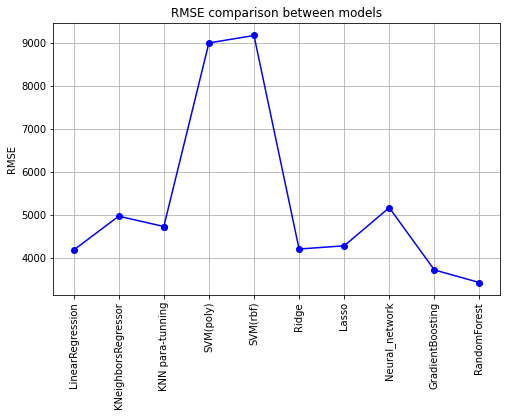

In [150]:
fig = plt.figure(num = 3, figsize=(8, 5))

plt.plot(name1, rmse1,color='blue', marker='o')  
plt.grid(True)
plt.xticks(rotation = 90)
plt.ylabel("RMSE")
plt.title("RMSE comparison between models")

plt.show()

In [151]:
lasso_model.best_params_

{'alpha': 64}

In [158]:
c1 =[]
m1=[]
m2=[]
for i in range(1, 9):
    n_components = 2 ** i
    #n_components = i
    pca = PCA(n_components=n_components)
    X_reduced_train = pca.fit_transform(X_train)
    X_reduced_test = pca.transform(X_test)

    lr = LinearRegression()
    lr = lr.fit(X_reduced_train, Y_train)
    Y_pred = lr.predict(X_reduced_test)
    c1.append(n_components)
    m1.append(sqrt(mean_squared_error(Y_test, Y_pred)))
    
    print ('MSE for ', n_components, ' components with LR ', mean_squared_error(Y_test, Y_pred))
    print ('RMSE for ', n_components, ' components with LR ', sqrt(mean_squared_error(Y_test, Y_pred)))

    gs_params = {'alpha':[2**i for i in range(-10,20)]}
    gc = GridSearchCV(estimator=Ridge(), param_grid=gs_params)
    ridge_model = gc.fit(X_reduced_train, Y_train)
    Y_pred = ridge_model.predict(X_reduced_test)
    m2.append(sqrt(mean_squared_error(Y_test, Y_pred)))
    print ('MSE for ', n_components, ' components with Ridge ', mean_squared_error(Y_test, Y_pred))
    print ('RMSE for ', n_components, ' components with Ridge ', sqrt(mean_squared_error(Y_test, Y_pred)))

MSE for  2  components with LR  53823518.72059407
RMSE for  2  components with LR  7336.451371105384
MSE for  2  components with Ridge  53825167.431647435
RMSE for  2  components with Ridge  7336.563734586338
MSE for  4  components with LR  40063608.752611496
RMSE for  4  components with LR  6329.582036170437
MSE for  4  components with Ridge  40079087.87613973
RMSE for  4  components with Ridge  6330.804678406982
MSE for  8  components with LR  37886231.85031863
RMSE for  8  components with LR  6155.179270363994
MSE for  8  components with Ridge  37909655.14330079
RMSE for  8  components with Ridge  6157.081706726068
MSE for  16  components with LR  32384776.864445683
RMSE for  16  components with LR  5690.762415041211
MSE for  16  components with Ridge  32462664.0639592
RMSE for  16  components with Ridge  5697.601606286561
MSE for  32  components with LR  28099275.54957958
RMSE for  32  components with LR  5300.874979621721
MSE for  32  components with Ridge  28123137.227231197
RMSE

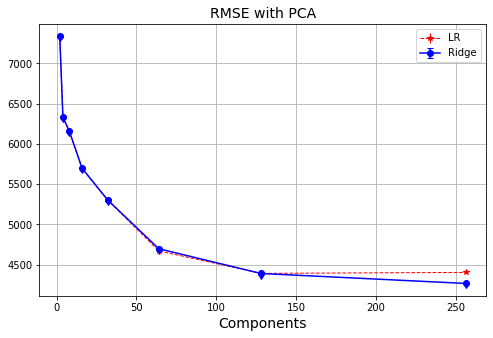

In [159]:
fig = plt.figure(num = 3, figsize=(8, 5))

yerr = np.linspace(0.05, 0.2, 8)

plt.errorbar(c1, m1, yerr=yerr,color='red',linewidth=1.0,linestyle='--',marker='*', label='LR')

plt.errorbar(c1, m2, yerr=yerr, uplims=True,color='blue', marker='o', label='Ridge')


plt.title('RMSE with PCA', fontsize=14)
plt.xlabel('Components', fontsize=14)

plt.grid(True)

plt.legend(loc='upper right')


plt.show()

In [216]:
from sklearn.feature_selection import SelectKBest, f_regression
c1 =[]
m1=[]
m2=[]
for i in range(1, 9):
    n_components = 2 ** i
    #n_components = i
    kbest = SelectKBest(f_regression, k=n_components)
    X_reduced_train = kbest.fit_transform(X_train, Y_train)
    X_reduced_test = kbest.transform(X_test)

    lr = LinearRegression()
    lr = lr.fit(X_reduced_train, Y_train)
    Y_pred = lr.predict(X_reduced_test)
    c1.append(n_components)
    m1.append(sqrt(mean_squared_error(Y_test, Y_pred)))
    print('MSE for ', n_components, ' components with LR ', mean_squared_error(Y_test, Y_pred))
    print('RMSE for ', n_components, ' components with LR ',sqrt(mean_squared_error(Y_test, Y_pred)) )

    gs_params = {'alpha':[2**i for i in range(-10,20)]}
    gc = GridSearchCV(estimator=Ridge(), param_grid=gs_params)
    ridge_model = gc.fit(X_reduced_train, Y_train)
    Y_pred = ridge_model.predict(X_reduced_test)
    m2.append(sqrt(mean_squared_error(Y_test, Y_pred)))
    print('MSE for ', n_components, ' components with Ridge ', mean_squared_error(Y_test, Y_pred))
    print('RMSE for ', n_components, ' components with Ridge ', sqrt(mean_squared_error(Y_test, Y_pred)))

MSE for  2  components with LR  49545031.69857724
RMSE for  2  components with LR  7038.823175686206
MSE for  2  components with Ridge  49556825.65732959
RMSE for  2  components with Ridge  7039.660904996034
MSE for  4  components with LR  41611034.9754779
RMSE for  4  components with LR  6450.66159207549
MSE for  4  components with Ridge  41637983.27556436
RMSE for  4  components with Ridge  6452.750055252749
MSE for  8  components with LR  40627867.819481716
RMSE for  8  components with LR  6373.99935829003
MSE for  8  components with Ridge  40567794.5939338
RMSE for  8  components with Ridge  6369.285249848196
MSE for  16  components with LR  34892294.78680094
RMSE for  16  components with LR  5906.970017428643
MSE for  16  components with Ridge  34829741.88641914
RMSE for  16  components with Ridge  5901.67280408014
MSE for  32  components with LR  26966549.73958325
RMSE for  32  components with LR  5192.932672352228
MSE for  32  components with Ridge  27079826.952098437
RMSE for  

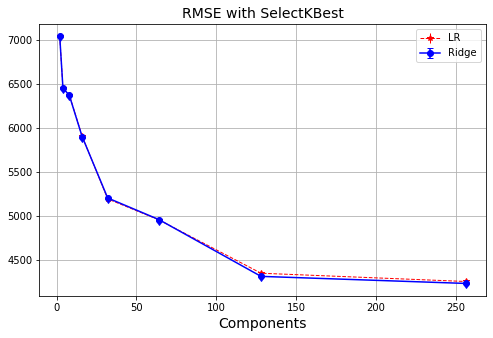

In [212]:
fig = plt.figure(num = 3, figsize=(8, 5))

yerr = np.linspace(0.05, 0.2, 8)

plt.errorbar(c1, m1, yerr=yerr,color='red',linewidth=1.0,linestyle='--',marker='*', label='LR')

plt.errorbar(c1, m2, yerr=yerr, uplims=True,color='blue', marker='o', label='Ridge')


plt.title('RMSE with SelectKBest', fontsize=14)
plt.xlabel('Components', fontsize=14)

plt.grid(True)

plt.legend(loc='upper right')


plt.show()

In [49]:
def forward_selection(df_x, df_y, k=None):

    if not k:
        k = len(df_x.columns)
    
    remaining = set(df_x.columns)
    selected = []

    while remaining and len(selected) <= k:
        scores = []
        for candidate in remaining:
            X = df_x[selected + [candidate]]
            lr = LinearRegression()
            lr = lr.fit(X, df_y)
            Y_pred = lr.predict(X)
            score = mean_squared_error(df_y, Y_pred)
            scores.append((score, candidate))
        
        score, best_candidate = min(scores)
        print(len(selected), score, best_candidate)
        
        remaining.remove(best_candidate)
        selected.append(best_candidate)
            
    return selected



In [50]:
selected = []
for i in range(1, 10):
    k = 10 * i
    fw_selected = forward_selection(df_xtrain, df_ytrain, k)
    selected.append((k, fw_selected))

0 50701439.53892914 PREDDEG_3
1 40832677.18483323 PAR_ED_N
2 33107390.317476794 IND_INC_PCT_LO
3 28928556.832470395 PCIP12
4 25359472.15898409 UGDS_ASIAN
5 23233045.629583195 DEP_INC_AVG
6 22314410.140300605 PCIP51
7 21458622.72610839 UGDS_WHITE
8 20876178.142127477 region_2.0
9 20340733.57678691 CONTROL_2
10 19794591.178506076 PCIP50
0 50701439.53892914 PREDDEG_3
1 40832677.18483323 PAR_ED_N
2 33107390.317476794 IND_INC_PCT_LO
3 28928556.832470395 PCIP12
4 25359472.15898409 UGDS_ASIAN
5 23233045.629583195 DEP_INC_AVG
6 22314410.140300605 PCIP51
7 21458622.72610839 UGDS_WHITE
8 20876178.142127477 region_2.0
9 20340733.57678691 CONTROL_2
10 19794591.178506076 PCIP50
11 19223373.146141086 CUML_DEBT_P90
12 18786783.778086364 PCIP13
13 18542234.848115336 CIP11CERT1
14 18314250.659531996 CIP22ASSOC
15 18091278.795367748 PCIP11
16 17740628.5434015 NOPELL_YR6_N
17 17202528.888747573 PELL_YR8_N
18 16953570.40798588 FIRSTGEN_YR4_N
19 16495630.695906103 PELL_YR2_N
20 16270188.705930607 NOT1STGEN

37 13802394.435016839 PCIP39
38 13715245.8144236 UGDS_UNKN
39 13619265.971688274 region_6.0
40 13528877.467351452 NOPELL_YR8_N
41 13437937.350994756 FIRSTGEN_YR6_N
42 13366071.71491861 PCIP44
43 13303777.554433433 CUML_DEBT_P75
44 13193975.503784405 NOTFIRSTGEN_DEBT_MDN
45 13130677.660377244 STABBR_MN
46 13066270.767216794 CIP51CERT1
47 13003792.608221253 PCIP14
48 12940498.093550207 STABBR_PA
49 12872886.485935291 COMP_ORIG_YR6_RT
50 12770921.0897934 COMP_ORIG_YR4_RT
51 12712079.542909555 WDRAW_ORIG_YR6_RT
52 12607727.420738189 NOLOAN_YR2_N
53 12515877.893060697 IND_YR2_N
54 12396154.45966272 CONTROL_1
55 12313712.78352033 FEMALE_DEBT_N
56 12260174.785704367 DEP_INC_N
57 12207133.66897593 COMP_ORIG_YR2_RT
58 12147339.072613275 LO_INC_DEBT_N
59 12100860.899499044 CIP22CERT2
60 12057507.03029914 WDRAW_ORIG_YR4_RT
61 12010594.599869784 PCIP48
62 11970857.278346095 CIP40CERT1
63 11930339.75029127 CUML_DEBT_P25
64 11880553.3716803 DEBT_MDN
65 11841416.127169456 FIRSTGEN_DEBT_N
66 11808239.

In [196]:
k_array = []
mean_array1 = []
for (k, fw_selected) in selected:
    model = LinearRegression()
    model = model.fit(df_xtrain[fw_selected], df_ytrain)
    Y_pred = model.predict(df_xtest[fw_selected])
    k_array.append(k)
    mean_array1.append(sqrt(mean_squared_error(df_ytest, Y_pred)))
    print (k, sqrt(mean_squared_error(df_ytest, Y_pred)))

print(mean_array1)

10 4975.632921984146
20 4485.608225975569
30 4311.55771636757
40 4228.919089367623
50 4180.087592873781
60 4094.9923867601865
70 4065.5538250780055
80 4088.1412588678522
90 4138.241002681669
[4975.632921984146, 4485.608225975569, 4311.55771636757, 4228.919089367623, 4180.087592873781, 4094.9923867601865, 4065.5538250780055, 4088.1412588678522, 4138.241002681669]


In [197]:
mean_array2 = []
for (k, fw_selected) in selected:
     
    model = KNeighborsRegressor(n_neighbors= 2)
    model = model.fit(df_xtrain[fw_selected], df_ytrain)
    Y_pred = model.predict(df_xtest[fw_selected])
    mean_array2.append(sqrt(mean_squared_error(df_ytest, Y_pred)))
    print (k, sqrt(mean_squared_error(df_ytest, Y_pred)))
    
print(mean_array2)

10 5499.504797794232
20 4845.9454622327985
30 4861.793661591521
40 4822.479664132769
50 4711.427197698257
60 4620.085284868393
70 4756.142112347815
80 4724.739438532266
90 4740.111714177771
[5499.504797794232, 4845.9454622327985, 4861.793661591521, 4822.479664132769, 4711.427197698257, 4620.085284868393, 4756.142112347815, 4724.739438532266, 4740.111714177771]


In [198]:
mean_array3 = []
for (k, fw_selected) in selected:
    mse = dict()
    for i in range(2, 15):
     
        model = KNeighborsRegressor(n_neighbors= i)
        model = model.fit(df_xtrain[fw_selected], df_ytrain)
        Y_pred = model.predict(df_xtest[fw_selected])
        mse[i] = mean_squared_error(df_ytest, Y_pred)
    print (k, sqrt(mean_squared_error(df_ytest, Y_pred)))
    mean_array3.append(sqrt(min(mse.values())))
print(mean_array3)


10 5396.75081986014
20 5077.058554544148
30 5096.524207482823
40 5119.379067503211
50 5013.658964748358
60 5009.191669592733
70 4954.82185669638
80 4890.178830028358
90 4908.593093204931
[5331.804249951672, 4845.9454622327985, 4861.793661591521, 4822.479664132769, 4634.485141603491, 4620.085284868393, 4588.8070666090225, 4697.086573294583, 4719.178542490874]


In [ ]:
mean_array4 = []
for (k, fw_selected) in selected:
     
    model = svm.SVR(kernel='poly')
    model = model.fit(df_xtrain[fw_selected], df_ytrain)
    Y_pred = model.predict(df_xtest[fw_selected])
    mean_array4.append(sqrt(mean_squared_error(df_ytest, Y_pred)))
    print (k, sqrt(mean_squared_error(df_ytest, Y_pred)))

In [ ]:
# rbf 
mean_array5 = []
for (k, fw_selected) in selected:
     
    model = svm.SVR(kernel='rbf')
    model = model.fit(df_xtrain[fw_selected], df_ytrain)
    Y_pred = model.predict(df_xtest[fw_selected])
    mean_array5.append(sqrt(mean_squared_error(df_ytest, Y_pred)))
    print (k, sqrt(mean_squared_error(df_ytest, Y_pred)))


In [186]:
mean_array6 = []
for (k, fw_selected) in selected:
     
    model = MLPRegressor(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=50000000)
    model = model.fit(df_xtrain[fw_selected], df_ytrain)
    Y_pred = model.predict(df_xtest[fw_selected])
    mean_array6.append(sqrt(mean_squared_error(df_ytest, Y_pred)))
    print (k, sqrt(mean_squared_error(df_ytest, Y_pred)))

10 7670.2150244300765
20 5954.2165872052865
30 6549.453150739778
40 6226.744739383237
50 6024.060863127957
60 4869.269152643064
70 5312.228488856202
80 5495.872423103292
90 5167.551370421129


In [187]:
#GradientBoostingRegressor
mean_array7 = []
for (k, fw_selected) in selected:
     
    model = GradientBoostingRegressor(random_state=0)
    model = model.fit(df_xtrain[fw_selected], df_ytrain)
    Y_pred = model.predict(df_xtest[fw_selected])
    mean_array7.append(sqrt(mean_squared_error(df_ytest, Y_pred)))
    print (k, sqrt(mean_squared_error(df_ytest, Y_pred)))


10 4392.703824089491
20 3955.4125746827394
30 3942.365943100029
40 3929.2703011160743
50 3883.689827066961
60 3788.2459044104594
70 3849.1771925497114
80 3836.10933945282
90 3750.748260444532


In [188]:
# Create a decision tree and cross-validate for accuracy
mean_array8 = []
for (k, fw_selected) in selected:
     
    model = RandomForestRegressor()
    model = model.fit(df_xtrain[fw_selected], df_ytrain)
    Y_pred = model.predict(df_xtest[fw_selected])
    mean_array8.append(sqrt(mean_squared_error(df_ytest, Y_pred)))
    print (k, sqrt(mean_squared_error(df_ytest, Y_pred)))


10 3994.676840394751
20 3767.806628908699
30 3690.051780368434
40 3612.3263091460135
50 3597.6595699164054
60 3481.0395468533666
70 3548.367883617
80 3506.5155425733196
90 3407.340445453127


In [189]:
gs_params = {'alpha':[2**i for i in range(-10,20)]}

mean_array9 = []
for (k, fw_selected) in selected:
    gc = GridSearchCV(estimator=Ridge(), param_grid=gs_params)
    model = gc.fit(df_xtrain[fw_selected], df_ytrain)
    Y_pred = model.predict(df_xtest[fw_selected])
    mean_array9.append(sqrt(mean_squared_error(df_ytest, Y_pred)))
    print (k, sqrt(mean_squared_error(df_ytest, Y_pred)))

10 4975.234523801505
20 4484.4399619932165
30 4303.282543131237
40 4211.047818108019
50 4152.405363644672
60 4085.3836608942256


c:\python38\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.36717e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


70 4056.39837749263


c:\python38\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.25258e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


80 4077.6234334228116


c:\python38\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.23727e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


90 4124.398270549959


In [190]:
gs_params = {'alpha':[2**i for i in range(-10,20)]}
mean_array10 = []
for (k, fw_selected) in selected:
    gc = GridSearchCV(estimator=Lasso(), param_grid=gs_params)
    model = gc.fit(df_xtrain[fw_selected], df_ytrain)
    Y_pred = model.predict(df_xtest[fw_selected])
    mean_array10.append(sqrt(mean_squared_error(df_ytest, Y_pred)))
    print (k, sqrt(mean_squared_error(df_ytest, Y_pred)))

10 4975.532096430275


c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12413625010.445627, tolerance: 11463754.052910052
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12620814028.726757, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11538680927.11246, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12630813593.341318, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11548408800.774467, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12426019476.31239, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13038565582.438803, tolerance: 11463754.052910052
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13248454523.44816, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12149359310.227562, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20140165487.637676, tolerance: 12083692.994047621
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22101465758.143158, tolerance: 11463754.052910052
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22324583866.867455, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want 

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4702193498.439655, tolerance: 11463754.052910052
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4130619942.2462425, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6137206965.929062, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to 

20 4519.312469323146


c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11490414720.155067, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10574983156.251606, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11188681214.33965, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11422928677.594704, tolerance: 11463754.052910052
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11506174193.168434, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10589608781.507921, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want t

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12445508926.284061, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11450101691.68318, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12161608865.46161, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to 

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22022839410.540627, tolerance: 11463754.052910052
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22235370232.003273, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20814635842.800476, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want t

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22867920433.067585, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21517987042.82712, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23353586678.68463, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to 

30 4451.284168229452


c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11031337148.68739, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10185378085.84555, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10649054366.683739, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to 

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10955608068.548548, tolerance: 11463754.052910052
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11050908743.053268, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10202927547.690697, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want t

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11812321145.167343, tolerance: 12083692.994047621
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12000966255.125908, tolerance: 11463754.052910052
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12168707881.796257, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want 

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19877460248.852715, tolerance: 12083692.994047621
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22041582027.20502, tolerance: 11463754.052910052
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22200976115.668198, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want t

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22449855330.91845, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22454866953.71911, tolerance: 12083692.994047621
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20258996364.009594, tolerance: 11463754.052910052
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to

40 4480.059147304132


c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10549541134.187864, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9835531679.504612, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10257810451.72038, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to 

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10571999158.001371, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9855844485.67006, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10279031652.22207, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to i

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11836830393.878487, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11003688615.283295, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11493545426.030317, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want t

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21678156774.83004, tolerance: 11463754.052910052
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21912208362.523384, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20521979665.964684, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22513035784.850193, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22290572634.96173, tolerance: 12083692.994047621
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20375604199.966564, tolerance: 11463754.052910052
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want t

50 4433.617998182787


c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9939971346.599127, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9287710910.07932, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9759951199.775927, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to in

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9966090981.284752, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9311926215.426401, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9783733194.669079, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to i

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11405057713.903774, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10641877907.069408, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11095043904.23415, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20651785392.92566, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19423898593.92487, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20489503782.314236, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to 

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18864741084.626984, tolerance: 12083692.994047621
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14919724197.527685, tolerance: 11463754.052910052
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14665453793.66398, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want t

60 4280.63929193832


c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9711291449.648262, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8935260269.928173, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9537081070.42769, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to in

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9746097821.419352, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8972556579.774471, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9574204700.020502, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to i

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11210049285.92134, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10347830278.68731, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10933872642.878279, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to 

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19157001033.719288, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20326109067.994946, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20650822304.575672, tolerance: 12083692.994047621
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want t

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18954864773.44516, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17888828524.23611, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19811401014.409836, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to 

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12612154602.15711, tolerance: 14750757.775661377
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9269281325.824532, tolerance: 11463754.052910052
  model = cd_fast.enet_coordinate_descent(


70 4234.121840904261


c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9486528783.832258, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8685012859.752934, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9332261460.345942, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to i

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9523286706.782839, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8725743440.762058, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9375351608.112879, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to i

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11035563494.418999, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10160239052.781782, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10803710386.884943, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want t

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20482036930.987534, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19156962344.309856, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20328809389.096928, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want t

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17857854593.93211, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19822069303.36424, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19823205401.44594, tolerance: 12083692.994047621
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to i

80 4225.824512662529


c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9160085815.922077, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8418870689.41988, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9160602472.952375, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to in

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9201166486.909143, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8460722811.896185, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9206273154.081774, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to i

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10772464440.856459, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9914792162.764036, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10666041913.716814, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20468332805.869144, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19152698657.142944, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20330626301.872437, tolerance: 11903699.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want t

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19099336374.761803, tolerance: 11463754.052910052
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19089529855.90217, tolerance: 12025451.976190476
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17854250094.61135, tolerance: 11522859.31679894
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to 

90 4263.557048509187


c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12117292437.466066, tolerance: 14750757.775661377
  model = cd_fast.enet_coordinate_descent(


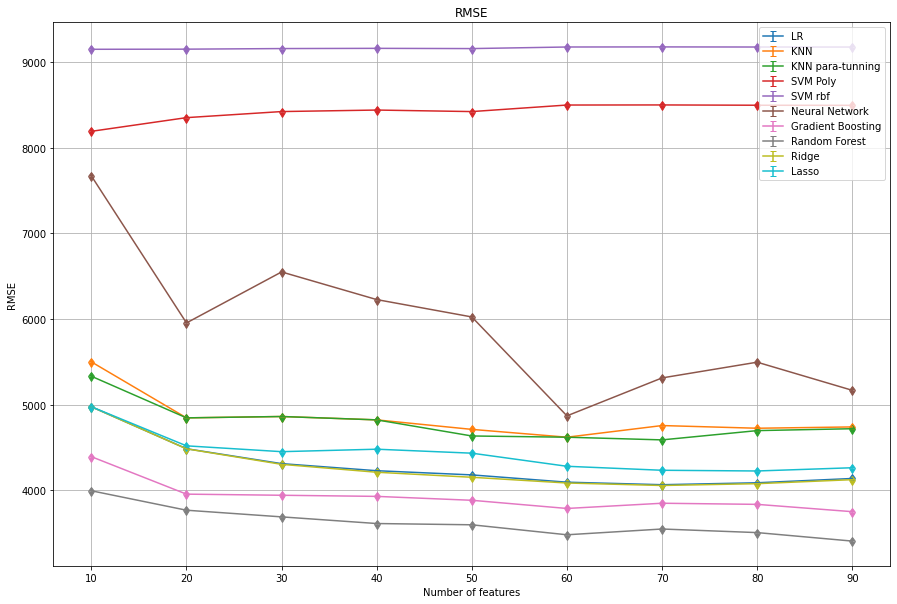

In [214]:

fig = plt.figure(num = 3, figsize=(15, 10))

yerr = np.linspace(0.05, 0.2, 9)

plt.errorbar(k_array, mean_array1, yerr=yerr,uplims=True, lolims=True,label='LR')
plt.errorbar(k_array, mean_array2, yerr=yerr,uplims=True, lolims=True,label='KNN')
plt.errorbar(k_array, mean_array3, yerr=yerr, uplims=True, lolims=True,label='KNN para-tunning')
plt.errorbar(k_array, mean_array4, yerr=yerr, uplims=True, lolims=True,label='SVM Poly')
plt.errorbar(k_array, mean_array5, yerr=yerr, uplims=True, lolims=True,label='SVM rbf')
plt.errorbar(k_array, mean_array6, yerr=yerr, uplims=True, lolims=True,label='Neural Network')
plt.errorbar(k_array, mean_array7, yerr=yerr, uplims=True, lolims=True,label='Gradient Boosting')
plt.errorbar(k_array, mean_array8, yerr=yerr, uplims=True, lolims=True,label='Random Forest')
plt.errorbar(k_array, mean_array9, yerr=yerr, uplims=True, lolims=True, label='Ridge')
plt.errorbar(k_array, mean_array10, yerr=yerr, uplims=True, lolims=True,label='Lasso')

plt.xlabel("Number of features")
plt.ylabel("RMSE")
plt.title("RMSE")
plt.grid(True)

plt.legend(loc='upper right')